In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
train_dir = r'D:\brain_tumor\Training'
test_dir = r'D:\brain_tumor\Testing'

In [3]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

In [5]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

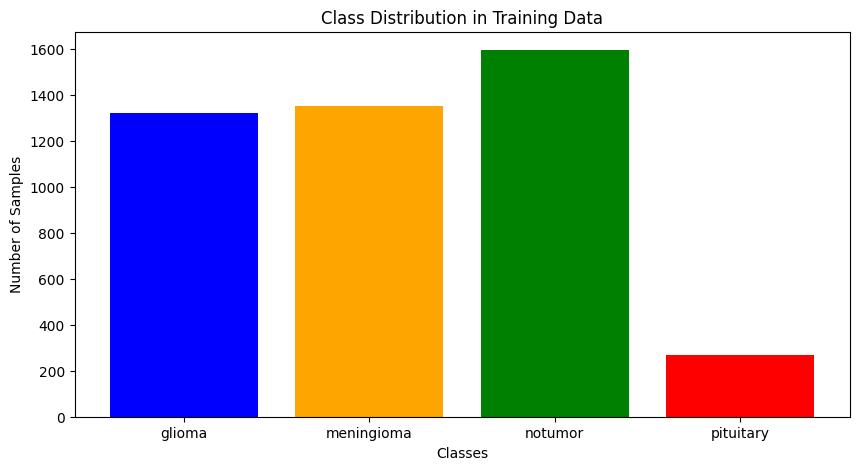

In [6]:
class_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in train_data.classes}

plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Class Distribution in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

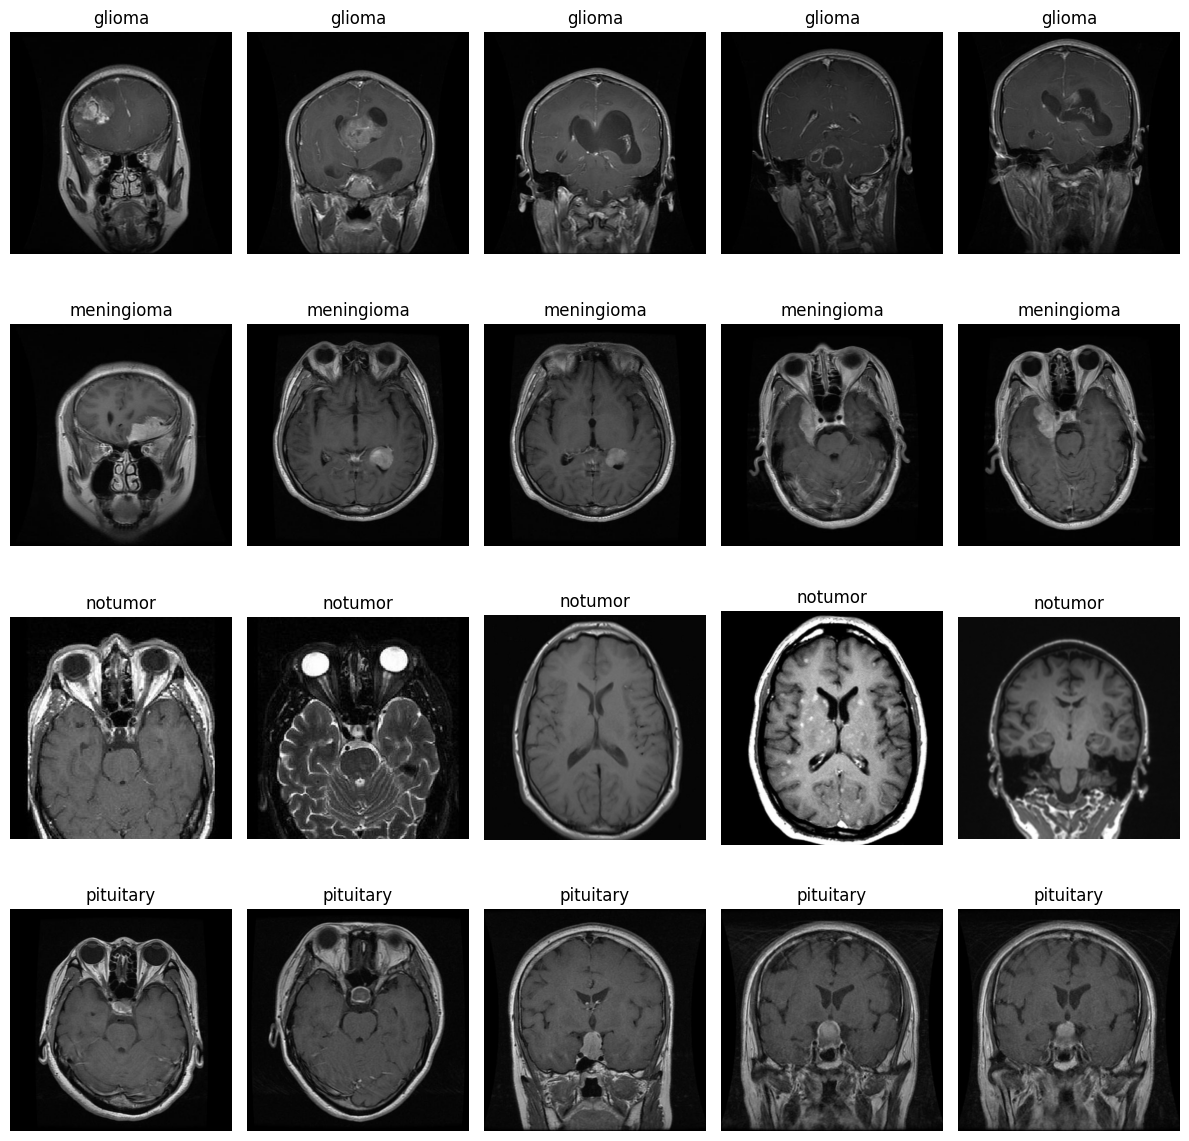

In [7]:
def show_images(dataset, class_names, num_images=5):
    fig, axes = plt.subplots(len(class_names), num_images, figsize=(12, 12))
    for i, cls in enumerate(class_names):
        class_dir = os.path.join(train_dir, cls)
        class_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)[:num_images]]
        for j, img_path in enumerate(class_files):
            image = plt.imread(img_path)
            axes[i, j].imshow(image)
            axes[i, j].set_title(cls)
            axes[i, j].axis('off')

class_names = list(class_counts.keys())
show_images(train_data, class_names)
plt.tight_layout()
plt.show()

In [8]:
class BrainTumorClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BrainTumorClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = BrainTumorClassifier(num_classes=len(train_data.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 25
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/25, Loss: 1.0696
Epoch 2/25, Loss: 0.8942
Epoch 3/25, Loss: 0.8435
Epoch 4/25, Loss: 0.7811
Epoch 5/25, Loss: 0.7199
Epoch 6/25, Loss: 0.6525
Epoch 7/25, Loss: 0.6272
Epoch 8/25, Loss: 0.6031
Epoch 9/25, Loss: 0.6131
Epoch 10/25, Loss: 0.5587
Epoch 11/25, Loss: 0.5549
Epoch 12/25, Loss: 0.5277
Epoch 13/25, Loss: 0.5202
Epoch 14/25, Loss: 0.5067
Epoch 15/25, Loss: 0.4854
Epoch 16/25, Loss: 0.4833
Epoch 17/25, Loss: 0.4644
Epoch 18/25, Loss: 0.4423
Epoch 19/25, Loss: 0.4403
Epoch 20/25, Loss: 0.4319
Epoch 21/25, Loss: 0.4376
Epoch 22/25, Loss: 0.4225
Epoch 23/25, Loss: 0.4258
Epoch 24/25, Loss: 0.4163
Epoch 25/25, Loss: 0.4199


In [49]:
!pip install matplotlib seaborn scikit-learn

Classification Report for Test Data:

              precision    recall  f1-score   support

      glioma       0.92      0.79      0.85       300
  meningioma       0.56      0.88      0.68       306
     notumor       0.93      0.99      0.95       405
   pituitary       0.99      0.46      0.63       300

    accuracy                           0.80      1311
   macro avg       0.85      0.78      0.78      1311
weighted avg       0.85      0.80      0.79      1311



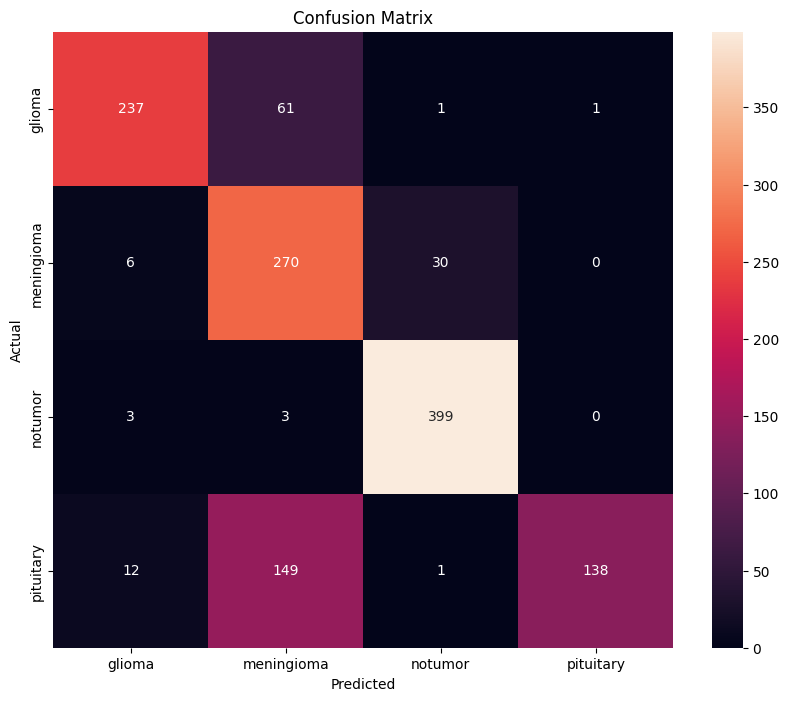

In [15]:
from sklearn.metrics import confusion_matrix, classification_report
def evaluate_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

test_preds, test_labels = evaluate_model(model, test_loader)

print("Classification Report for Test Data:\n")
print(classification_report(test_labels, test_preds, target_names=test_data.classes))

conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=test_data.classes, yticklabels=test_data.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [43]:
model_path = 'model_new_diseases.pth'
torch.save(model.state_dict(), model_path)
print("Model saved successfully at", model_path)

# Verify the save location
print("Current working directory:", os.getcwd())
print("Files in the directory:", os.listdir())


Model saved successfully at model_new_diseases.pth
Current working directory: D:\JN
Files in the directory: ['.ipynb_checkpoints', 'Brain_TM.ipynb', 'GPT_CODE.ipynb', 'model_new_diseases.pth', 'niraj_diseases.ipynb']


In [52]:
def load_model(model_path, num_classes):
    model = BrainTumorClassifier(num_classes=num_classes)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Load the model
loaded_model = load_model('model_new_diseases.pth', num_classes=len(train_data.classes))

# Prediction function
def predict_brain_tumor(image_path, model, transform, class_names):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        class_index = predicted.item()
        class_label = class_names[class_index]
        confidence = torch.nn.functional.softmax(output, dim=1)[0][class_index].item()
    return class_label, confidence

# Example usage
image_path = r"C:\Users\Aniketkadam\Pictures\Screenshots\Screenshot 2024-05-23 005833.png"
predicted_class, confidence = predict_brain_tumor(image_path, loaded_model, test_transforms, test_data.classes)
print("Predicted class:", predicted_class)
print("Confidence:", confidence)


Predicted class: notumor
Confidence: 0.8591729402542114
